# Cloud Inpainting on SEN3 Data
This notebook is a quick test to load, mask with clouds and then try and recover the data hidden by clouds using an inpainting DL model

In [1]:
import utils.prepare_dataset as predat
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from network.model import GenModel
from network.loss import lossL1
import keras


2024-06-20 07:58:54.077843: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 07:58:54.078327: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 07:58:54.082004: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 07:58:54.128026: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 07:58:54.961313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Extracting the bands from the Xarrays

The goal here is to convert the data into a more tensorflow friendly data format

In [2]:
dsnp_c = np.moveaxis(np.load("Cloudy_DS.npy"),3,0)
dsnp = np.moveaxis(np.load("Ground_truth.npy"),3,0)

In [5]:
#Data normalisation

for i in range(dsnp.shape[3]):
    for j in range(11):
        dsnp[:,:,i,j] = (dsnp[:,:,i,j] - np.min(dsnp[:,:,i,j]))/(np.max(dsnp[:,:,i,j]) - np.min(dsnp[:,:,i,j]))
        dsnp_c[:,:,i,j] = (dsnp_c[:,:,i,j] - np.min(dsnp_c[:,:,i,j]))/(np.max(dsnp_c[:,:,i,j]) - np.min(dsnp_c[:,:,i,j]))

In [6]:
#Split into training and test set


train_ds = tf.data.Dataset.from_tensor_slices((dsnp_c[:800,:,:,:], dsnp[:800,:,:,:]))
test_ds = tf.data.Dataset.from_tensor_slices((dsnp_c[800:,:,:,:], dsnp[800:,:,:,:]))

In [7]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 800

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.batch(BATCH_SIZE)

In [8]:
model = GenModel()
coarseNet = model.coarseNet
coarseNet.compile(optimizer='adam', loss="mae", metrics=['mean_absolute_error'])
print(coarseNet.summary())


/home/etienne/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'gated_conv2d_16', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gated_conv2d (GatedConv2D)      │ (None, 256, 256, 32)   │        19,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_1 (GatedConv2D)    │ (None, 128, 128, 64)   │        65,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_2 (GatedConv2D)    │ (None, 128, 128, 64)   │       131,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_3 (GatedConv2D)    │ (None, 64, 64, 128)    │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_4 (GatedConv2D)    │ (None, 64, 64, 128)    │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_5 (GatedConv2D)    │ (None, 64, 64, 128)    │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_6 (GatedConv2D)    │ (None, 64, 64, 128)    │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_7 (GatedConv2D)    │ (None, 64, 64, 128)    │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_8 (GatedConv2D)    │ (None, 64, 64, 128)    │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_9 (GatedConv2D)    │ (None, 64, 64, 128)    │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_10 (GatedConv2D)   │ (None, 64, 64, 128)    │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_de_conv2d (GatedDeConv2D) │ (None, 128, 128, 64)   │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_12 (GatedConv2D)   │ (None, 128, 128, 64)   │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_de_conv2d_1               │ (None, 256, 256, 32)   │        65,728 │
│ (GatedDeConv2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_14 (GatedConv2D)   │ (None, 256, 256, 32)   │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_15 (GatedConv2D)   │ (None, 256, 256, 16)   │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_16 (GatedConv2D)   │ (None, 256, 256, 11)   │         3,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,602 (10.50 MB)

 Trainable params: 2,750,796 (10.49 MB)

 Non-trainable params: 2,806 (10.96 KB)

None


In [9]:
np.max(dsnp_c[:,:,:,0])

1.0

2024-06-20 08:07:33.023068: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


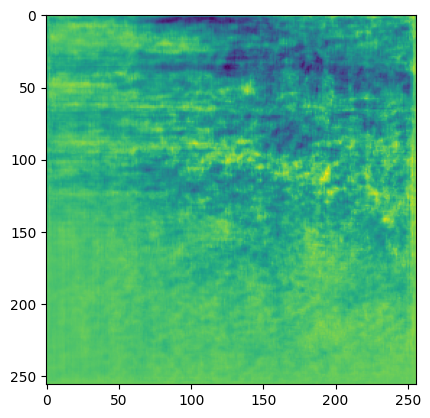

In [10]:
inp = train_ds.take(1)
out = coarseNet.predict(inp)
plt.imshow(out[0,:,:,0])


In [12]:
coarseNet.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), keras.callbacks.ModelCheckpoint(filepath='coarseNet.keras', save_best_only=True), keras.callbacks.TensorBoard(log_dir='./logs'), keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0), keras.callbacks.CSVLogger('coarseNet.csv'), keras.callbacks.TerminateOnNaN()])

Epoch 1/100


2024-06-20 08:09:43.185099: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_1/gated_de_conv2d_1_2/gated_conv2d_13_1/activation_26_1/leaky_re_lu_1_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_1/gated_de_conv2d_1_2/gated_conv2d_13_1/conv2d_26_1/add'.
2024-06-20 08:09:43.550419: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


13/13 ━━━━━━━━━━━━━━━━━━━━ 351s 26s/step - loss: 0.2037 - mean_absolute_error: 0.2037 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 335s 26s/step - loss: 0.0277 - mean_absolute_error: 0.0277 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 335s 26s/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 334s 26s/step - loss: 0.0155 - mean_absolute_error: 0.0155 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198 - learning_rate: 0.0010
Epoch 5/100
 3/13 ━━━━━━━━━━━━━━━━━━━━ 4:11 25s/step - loss: 0.0128 - mean_absolute_error: 0.0128

In [ ]:
validation_loss = coarseNet.evaluate(test_ds)

In [ ]:
train_iterator = train_ds.as_numpy_iterator()
test_iterator = test_ds.as_numpy_iterator()

# Extract the data from the iterators
train_data = list(train_iterator)
test_data = list(test_iterator)

# Separate the inputs (dsnp_c) and labels (dsnp) for training and test sets
train_dsnp_c, train_dsnp = zip(*train_data)
test_dsnp_c, test_dsnp = zip(*test_data)

# Concatenate the training and test sets
bdsnp_c = np.concatenate(train_dsnp_c + test_dsnp_c, axis=0)
bdsnp = np.concatenate(train_dsnp + test_dsnp, axis=0)

plt.subplot(1,3,1)
plt.imshow(bdsnp[0,:,:,1])
plt.subplot(1,3,2)
plt.imshow(bdsnp_c[0,:,:,1])
plt.subplot(1,3,3)
out2 = coarseNet.predict(bdsnp_c[0:1,:,:,:])
plt.imshow(out2[0,:,:,1])

print("Max value for GT is {}, cloudy is {}, predicted is {}".format(np.max(bdsnp), np.max(bdsnp_c[:,:,:,1:11]), np.max(out2)))

